1. Upload Your Dataset

In [ ]:
import glob
from google.colab import files

# Upload dataset to /content
uploaded = files.upload()
for fn in uploaded.keys():
    print("Uploaded:", fn)

# List CSVs present
print("\nCSV files in /content:")
print(glob.glob("/content/*.csv"))


**Load and Preview Data**

In [6]:
import pandas as pd
import glob

# Auto-detect CSV in /content (prefers anonymized if available)
csv_candidates = glob.glob("/content/*.csv")
if not csv_candidates:
    raise FileNotFoundError("❌ No CSV found in /content. Please run the upload cell first.")

preferred = "/content/anonymized_attribution.csv"
csv_path = preferred if preferred in csv_candidates else csv_candidates[0]

print("✅ Loading:", csv_path)
df = pd.read_csv(csv_path)

print("Shape:", df.shape)
display(df.head(10))


✅ Loading: /content/multi_touch_attribution_data.csv
Shape: (10000, 5)


,User ID,Timestamp,Channel,Campaign,Conversion
0,83281,2025-02-10 07:58:51,Email,New Product Launch,No
1,68071,2025-02-10 23:38:48,Search Ads,Winter Sale,No
2,90131,2025-02-11 10:41:07,Social Media,Brand Awareness,Yes
3,71026,2025-02-10 08:19:44,Direct Traffic,-,Yes
4,94486,2025-02-10 15:15:46,Email,Retargeting,Yes
5,31134,2025-02-11 06:43:06,Search Ads,-,Yes
6,99995,2025-02-10 06:15:30,Search Ads,-,Yes
7,45832,2025-02-11 01:09:27,Referral,Winter Sale,Yes
8,79863,2025-02-10 06:48:56,Display Ads,Discount Offer,Yes
9,35324,2025-02-10 21:36:24,Direct Traffic,-,No


**Clean & Anonymize**

In [7]:
# Cell 3 — Clean & anonymize dataset (robust)
import pandas as pd
import uuid
import glob
import os

# Auto-detect loaded CSV (prefer already uploaded anonymized file)
csv_candidates = glob.glob("/content/*.csv")
if not csv_candidates:
    raise FileNotFoundError("No CSV found in /content. Please upload the dataset (use upload cell).")

# prefer a file already called anonymized_attribution.csv, else first CSV
preferred = "/content/anonymized_attribution.csv"
csv_path = preferred if preferred in csv_candidates else csv_candidates[0]
print("Using:", csv_path)

df = pd.read_csv(csv_path)
print("Initial shape:", df.shape)

# --- Detect likely columns ---
cols_lower = [c.lower() for c in df.columns]

# Channel column detection
channel_col = None
for c in df.columns:
    if "channel" in c.lower():
        channel_col = c
        break
if channel_col is None:
    raise ValueError("Could not detect a Channel column. Make sure your CSV has a Channel column.")

# User id detection
user_col = None
for c in df.columns:
    low = c.lower().replace(" ", "")
    if low in ("userid", "user_id", "user"):
        user_col = c
        break

# Conversion detection
conv_col = None
for c in df.columns:
    if "conv" in c.lower() or "conversion" in c.lower():
        conv_col = c
        break

# Timestamp detection (optional)
ts_col = None
for c in df.columns:
    if "time" in c.lower() or "timestamp" in c.lower() or "date" in c.lower():
        ts_col = c
        break

# --- Build User_ID_Anon if not present ---
if "User_ID_Anon" not in df.columns:
    if user_col:
        print("Detected user id column:", user_col, " -> creating User_ID_Anon")
        unique_ids = df[user_col].unique()
        user_map = {u: uuid.uuid4().hex[:8] for u in unique_ids}
        df["User_ID_Anon"] = df[user_col].map(user_map)
    else:
        print("No user id column found -> creating synthetic User_ID_Anon")
        df["User_ID_Anon"] = [uuid.uuid4().hex[:8] for _ in range(len(df))]

# --- Conversion flag normalization ---
if "Conversion_Flag" not in df.columns:
    if conv_col:
        print("Detected conversion column:", conv_col, "-> normalizing to Conversion_Flag (1/0)")
        df["Conversion_Flag"] = df[conv_col].astype(str).str.lower().map(
            lambda x: 1 if x in ("1","true","yes","y","converted") else 0
        ).fillna(0).astype(int)
    else:
        print("No conversion column detected -> defaulting Conversion_Flag to 0")
        df["Conversion_Flag"] = 0
else:
    # ensure it's 0/1
    df["Conversion_Flag"] = df["Conversion_Flag"].astype(int).apply(lambda x: 1 if x==1 else 0)

# --- Channel rename ---
df = df.rename(columns={channel_col: "Channel"})

# --- Create Step_Order if missing ---
if "Step_Order" not in df.columns:
    if ts_col and ts_col in df.columns:
        print("Using timestamp column", ts_col, "to create Step_Order.")
        df[ts_col] = pd.to_datetime(df[ts_col], errors="coerce")
        df = df.sort_values(["User_ID_Anon", ts_col])
        df["Step_Order"] = df.groupby("User_ID_Anon").cumcount() + 1
    else:
        print("No timestamp found -> creating Step_Order from current order per user.")
        df = df.sort_values(["User_ID_Anon"])
        df["Step_Order"] = df.groupby("User_ID_Anon").cumcount() + 1
else:
    print("Step_Order already present; using existing values.")

# --- Keep safe columns for downstream modelling ---
safe_cols = ["User_ID_Anon", "Timestamp", "Step_Order", "Channel", "Conversion_Flag"]
# If Timestamp isn't present with that exact name, attempt to set it
if "Timestamp" not in df.columns:
    if ts_col and ts_col in df.columns:
        df = df.rename(columns={ts_col: "Timestamp"})
    else:
        df["Timestamp"] = pd.NaT

df_safe = df.loc[:, [c for c in safe_cols if c in df.columns]]

# Save anonymized CSV
out_path = "/content/anonymized_attribution.csv"
df_safe.to_csv(out_path, index=False)
print("✅ Saved anonymized dataset to:", out_path)
print("Sanity check — head of anonymized dataset:")
display(df_safe.head(10))


Using: /content/multi_touch_attribution_data.csv
Initial shape: (10000, 5)
Detected user id column: User ID  -> creating User_ID_Anon
Detected conversion column: Conversion -> normalizing to Conversion_Flag (1/0)
Using timestamp column Timestamp to create Step_Order.
✅ Saved anonymized dataset to: /content/anonymized_attribution.csv
Sanity check — head of anonymized dataset:


,User_ID_Anon,Timestamp,Step_Order,Channel,Conversion_Flag
5468,0012a996,2025-02-10 09:56:25,1,Direct Traffic,1
6365,0012a996,2025-02-11 07:11:51,2,Search Ads,1
7915,0012a996,2025-02-11 13:50:40,3,Display Ads,1
9481,0012a996,2025-02-11 23:23:33,4,Search Ads,1
3486,00159247,2025-02-10 06:13:04,1,Direct Traffic,0
4469,00159247,2025-02-10 07:07:37,2,Referral,0
1978,00159247,2025-02-11 23:40:34,3,Referral,1
4545,00297c7d,2025-02-10 07:10:03,1,Direct Traffic,1
7750,00297c7d,2025-02-10 10:32:53,2,Search Ads,1
1753,00297c7d,2025-02-10 13:19:37,3,Email,1


**Build User Journeys**

In [8]:
# Cell 4 — Build journeys
import pandas as pd

# Load the anonymized dataset (from Cell 3)
df = pd.read_csv("/content/anonymized_attribution.csv")

# Ensure correct order
df["Step_Order"] = pd.to_numeric(df["Step_Order"], errors="coerce").fillna(1).astype(int)
df = df.sort_values(["User_ID_Anon","Step_Order"])

# Group into journeys: one row per user
journeys = (
    df.groupby("User_ID_Anon")
      .agg({"Channel": list, "Conversion_Flag": "max"})
      .reset_index()
)

# Only keep non-empty journeys
journeys = journeys[journeys["Channel"].map(len) > 0].reset_index(drop=True)

print("✅ Number of journeys built:", len(journeys))
display(journeys.head(10))


✅ Number of journeys built: 2847


,User_ID_Anon,Channel,Conversion_Flag
0,0012a996,"[Direct Traffic, Search Ads, Display Ads, Sear...",1
1,00159247,"[Direct Traffic, Referral, Referral]",1
2,00297c7d,"[Direct Traffic, Search Ads, Email, Display Ads]",1
3,003e67a6,"[Direct Traffic, Social Media, Search Ads, Dir...",1
4,0069d322,"[Search Ads, Direct Traffic, Direct Traffic, R...",1
5,006eddd9,"[Referral, Social Media]",1
6,00ca8875,"[Social Media, Display Ads, Direct Traffic, So...",1
7,00cd3457,"[Referral, Search Ads, Email, Social Media, Di...",1
8,0103995b,"[Referral, Email]",1
9,011070cf,"[Social Media, Display Ads]",1


**Rule-Based Attribution Models**

✅ Saved to /content/rule_based_attribution.csv


,channel,first_touch_pct,last_touch_pct,linear_pct
0,Direct Traffic,17.261655,17.849643,17.147272
1,Display Ads,17.975640,16.841663,17.100217
2,Email,15.707686,16.505670,16.283779
3,Referral,17.135657,16.127677,16.745273
4,Search Ads,15.581688,16.589668,16.024437
5,Social Media,16.337673,16.085678,16.699022


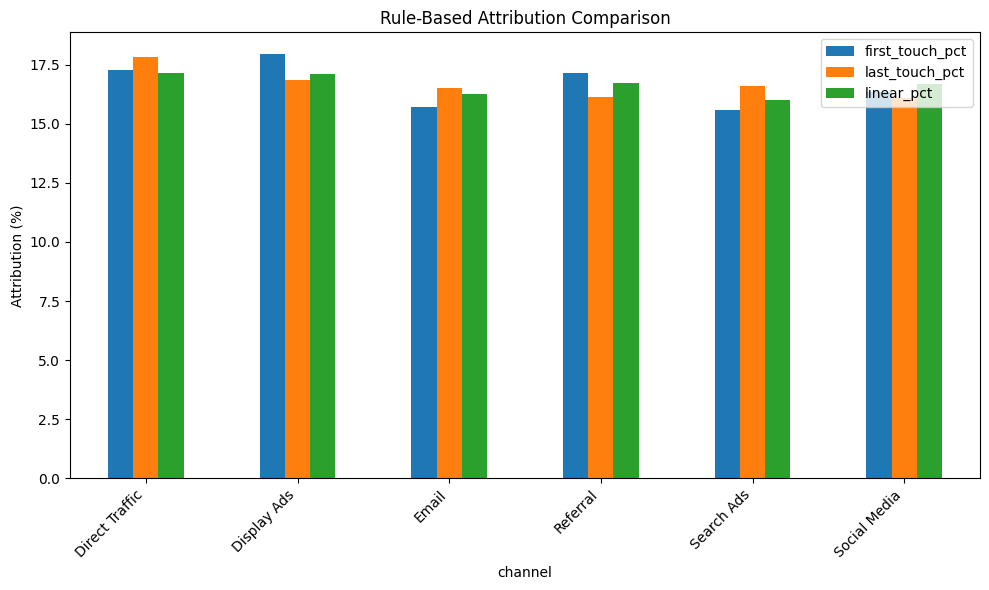

✅ Saved bar chart to: /content/rule_based_attribution.png


In [9]:
# Cell 5 — Rule-Based Attribution

import matplotlib.pyplot as plt

# Use journeys created in Cell 4
converted_paths = journeys[journeys["Conversion_Flag"] == 1]["Channel"].tolist()

# Attribution functions
def first_touch(paths):
    credits = {}
    for p in paths:
        credits[p[0]] = credits.get(p[0], 0) + 1
    return credits

def last_touch(paths):
    credits = {}
    for p in paths:
        credits[p[-1]] = credits.get(p[-1], 0) + 1
    return credits

def linear(paths):
    credits = {}
    for p in paths:
        share = 1 / len(p)
        for ch in p:
            credits[ch] = credits.get(ch, 0) + share
    return credits

# Calculate
ft = first_touch(converted_paths)
lt = last_touch(converted_paths)
lin = linear(converted_paths)

# Normalize to percentages
def normalize(d):
    s = sum(d.values())
    return {k:(v/s)*100 if s>0 else 0 for k,v in d.items()}

ft_pct = normalize(ft)
lt_pct = normalize(lt)
lin_pct = normalize(lin)

# Combine results into DataFrame
all_channels = sorted(set(ft_pct) | set(lt_pct) | set(lin_pct))
rule_df = pd.DataFrame({
    "channel": all_channels,
    "first_touch_pct": [ft_pct.get(c,0) for c in all_channels],
    "last_touch_pct": [lt_pct.get(c,0) for c in all_channels],
    "linear_pct": [lin_pct.get(c,0) for c in all_channels]
})

# Save to CSV
rule_df.to_csv("/content/rule_based_attribution.csv", index=False)
print("✅ Saved to /content/rule_based_attribution.csv")
display(rule_df)

# Plot and save chart
ax = rule_df.set_index("channel")[["first_touch_pct","last_touch_pct","linear_pct"]].plot(
    kind="bar", figsize=(10,6)
)
ax.set_ylabel("Attribution (%)")
ax.set_title("Rule-Based Attribution Comparison")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()

out_png = "/content/rule_based_attribution.png"
plt.savefig(out_png, dpi=150, bbox_inches="tight")
plt.show()
print("✅ Saved bar chart to:", out_png)


**Markov Chain Attribution**

Base conversion probability: 0.836319
✅ Saved to /content/markov_attribution_comparison.csv


,channel,markov_pct
0,Direct Traffic,17.046075
1,Referral,16.833827
2,Email,16.754111
3,Social Media,16.526301
4,Search Ads,16.446936
5,Display Ads,16.392750


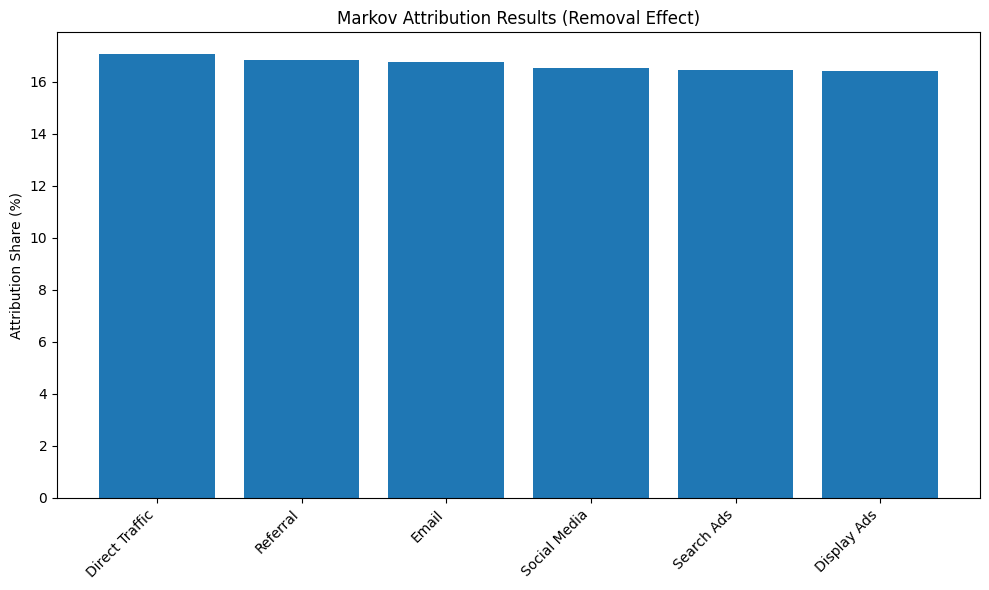

✅ Saved bar chart to: /content/markov_attribution.png


In [10]:
# Cell 6 — Markov Chain Attribution

from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt

# Use journeys built earlier
paths = journeys["Channel"].tolist()
conv_flags = journeys["Conversion_Flag"].tolist()

# Step 1: Build transition counts
trans_counts = defaultdict(lambda: defaultdict(int))
start_counts = defaultdict(int)

for path, conv in zip(paths, conv_flags):
    if not path: continue
    start_counts[path[0]] += 1
    trans_counts["start"][path[0]] += 1
    for a,b in zip(path, path[1:]):
        trans_counts[a][b] += 1
    last = path[-1]
    trans_counts[last]["conversion" if conv==1 else "null"] += 1

# Step 2: Build Q and R matrices
channels = sorted({c for p in paths for c in p})
absorbing = ["conversion","null"]
state_idx = {s:i for i,s in enumerate(channels)}
abs_idx = {a:i for i,a in enumerate(absorbing)}
k = len(channels)

Q = np.zeros((k,k))
R = np.zeros((k,len(absorbing)))

for s in channels:
    i = state_idx[s]
    total_out = sum(trans_counts[s].values())
    if total_out == 0:
        R[i, abs_idx["null"]] = 1.0
        continue
    for t,cnt in trans_counts[s].items():
        if t in state_idx:
            Q[i, state_idx[t]] = cnt/total_out
        elif t in abs_idx:
            R[i, abs_idx[t]] = cnt/total_out
        else:
            R[i, abs_idx["null"]] += cnt/total_out

# Step 3: Base conversion probability
total_starts = sum(start_counts.values())
pi = np.array([start_counts.get(s,0)/total_starts for s in channels]) if total_starts>0 else np.ones(k)/k
pi = pi/pi.sum()
I = np.eye(k)
N = np.linalg.pinv(I - Q)   # fundamental matrix
B = N.dot(R)
conv_from_state = B[:, abs_idx["conversion"]]
base_conv_prob = float(np.dot(pi, conv_from_state))
print("Base conversion probability:", round(base_conv_prob,6))

# Step 4: Removal effect
removal_effects = {}
for i,ch in enumerate(channels):
    mask = [j for j in range(k) if j != i]
    if not mask:
        removal_effects[ch] = 0.0
        continue
    Qp = Q[np.ix_(mask,mask)]
    Rp = R[np.ix_(mask, list(range(R.shape[1])))]
    pip = pi[mask]
    pip = pip/pip.sum() if pip.sum()>0 else np.ones(len(mask))/len(mask)
    Np = np.linalg.pinv(np.eye(len(mask)) - Qp)
    Bp = Np.dot(Rp)
    conv_without = float(np.dot(pip, Bp[:, abs_idx["conversion"]]))
    removal_effects[ch] = base_conv_prob - conv_without

# Step 5: Normalize to percentages
total_re = sum(removal_effects.values())
markov_pct = {ch: (v/total_re)*100 if total_re>0 else 0.0 for ch,v in removal_effects.items()}

markov_df = pd.DataFrame(sorted(markov_pct.items(), key=lambda x: x[1], reverse=True),
                         columns=["channel","markov_pct"])

# Save to CSV
markov_df.to_csv("/content/markov_attribution_comparison.csv", index=False)
print("✅ Saved to /content/markov_attribution_comparison.csv")
display(markov_df)

# Step 6: Plot and save bar chart
plt.figure(figsize=(10,6))
plt.bar(markov_df["channel"], markov_df["markov_pct"], color="tab:blue")
plt.ylabel("Attribution Share (%)")
plt.title("Markov Attribution Results (Removal Effect)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
out_png = "/content/markov_attribution.png"
plt.savefig(out_png, dpi=150, bbox_inches="tight")
plt.show()
print("✅ Saved bar chart to:", out_png)


**Shapley attribution**

Channels (n=6): ['Direct Traffic', 'Display Ads', 'Email', 'Referral', 'Search Ads', 'Social Media']
Computing exact Shapley over all permutations (n! permutations)...
Shapley computation finished in 0.2s
✅ Saved Shapley comparison to /content/shapley_attribution_comparison.csv


,channel,first_touch_pct,last_touch_pct,linear_pct,markov_pct,shapley_pct
0,Direct Traffic,17.261655,17.849643,17.147272,17.046075,17.543786
1,Display Ads,17.975640,16.841663,17.100217,16.392750,16.777188
2,Email,15.707686,16.505670,16.283779,16.754111,16.696312
3,Referral,17.135657,16.127677,16.745273,16.833827,16.133859
4,Search Ads,15.581688,16.589668,16.024437,16.446936,16.648292
5,Social Media,16.337673,16.085678,16.699022,16.526301,16.200563


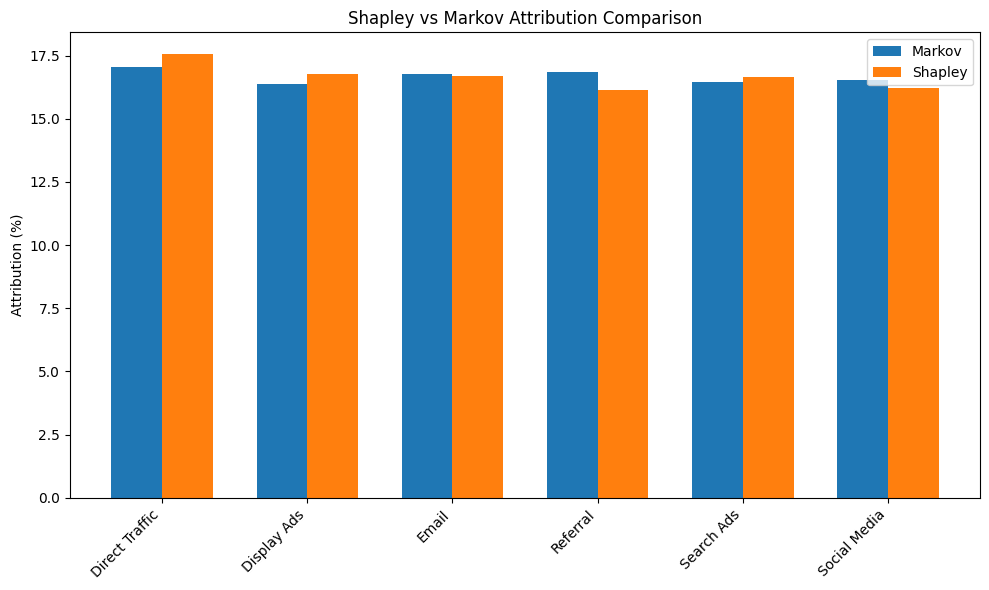

✅ Saved chart to: /content/shapley_vs_markov_comparison.png


In [11]:
# Cell 7 — Shapley-value attribution (compute, compare, plot)
import time
import random
import itertools
import math
from functools import lru_cache
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Safety checks: ensure required objects exist
try:
    journeys  # from Cell 4
    trans_counts  # from Cell 6 markov build
    start_counts
except NameError as e:
    raise RuntimeError("Run previous cells (up through Markov) before running Shapley. Missing: " + str(e))

# Build channel list (same order used earlier)
all_channels = sorted({c for p in journeys["Channel"] for c in p})
n_channels = len(all_channels)
print("Channels (n={}): {}".format(n_channels, all_channels))

# Helper: conversion probability if only channels in S are available (Markov-style)
def conv_prob_for_channels(S):
    S = list(S)
    if len(S) == 0:
        return 0.0
    absorbing = ["conversion", "null"]
    state_idx_local = {s:i for i,s in enumerate(S)}
    abs_idx_local = {a:i for i,a in enumerate(absorbing)}
    k_local = len(S)
    Q_local = np.zeros((k_local,k_local), dtype=float)
    R_local = np.zeros((k_local, len(absorbing)), dtype=float)
    for s in S:
        i = state_idx_local[s]
        total_out = sum(trans_counts[s].values())
        if total_out == 0:
            R_local[i, abs_idx_local["null"]] = 1.0
            continue
        for t, cnt in trans_counts[s].items():
            if t in state_idx_local:
                Q_local[i, state_idx_local[t]] = cnt / total_out
            elif t in abs_idx_local:
                R_local[i, abs_idx_local[t]] = cnt / total_out
            else:
                R_local[i, abs_idx_local["null"]] += cnt / total_out
    # start distribution for S
    total_starts_global = sum(start_counts.values())
    if total_starts_global == 0:
        pi_local = np.ones(k_local) / k_local
    else:
        pi_local = np.array([start_counts.get(s,0)/total_starts_global for s in S], dtype=float)
        if pi_local.sum() == 0:
            pi_local = np.ones(k_local) / k_local
        else:
            pi_local = pi_local / pi_local.sum()
    # fundamental matrix & conversion prob
    try:
        N_local = np.linalg.pinv(np.eye(k_local) - Q_local)
        B_local = N_local.dot(R_local)
        conv_prob = float(np.dot(pi_local, B_local[:, abs_idx_local["conversion"]]))
        return conv_prob
    except Exception:
        return 0.0

# Cache wrapper
@lru_cache(maxsize=None)
def conv_prob_cache(tup):
    return conv_prob_for_channels(list(tup))

# Decide exact vs Monte-Carlo
shapley = {ch: 0.0 for ch in all_channels}
start_time = time.time()
if n_channels <= 8:
    print("Computing exact Shapley over all permutations (n! permutations)...")
    perms = list(itertools.permutations(all_channels))
    fact = math.factorial(n_channels)
    for perm in perms:
        prev = []
        v_prev = conv_prob_cache(tuple(prev))
        for ch in perm:
            prev_with = tuple(prev + [ch])
            v_with = conv_prob_cache(prev_with)
            marginal = v_with - v_prev
            shapley[ch] += marginal
            prev = list(prev_with)
            v_prev = v_with
    for ch in shapley:
        shapley[ch] /= fact
else:
    n_samples = 3000  # adjust for speed/accuracy
    print(f"n={n_channels} > 8 — using Monte-Carlo Shapley with {n_samples} samples.")
    for s in range(n_samples):
        perm = random.sample(all_channels, k=n_channels)
        prev = []
        v_prev = conv_prob_cache(tuple(prev))
        for ch in perm:
            prev_with = tuple(prev + [ch])
            v_with = conv_prob_cache(prev_with)
            marginal = v_with - v_prev
            shapley[ch] += marginal
            prev = list(prev_with)
            v_prev = v_with
    for ch in shapley:
        shapley[ch] /= float(n_samples)

elapsed = time.time() - start_time
print("Shapley computation finished in {:.1f}s".format(elapsed))

# Normalize Shapley to percentages
total_sh = sum(shapley.values())
shapley_pct = {ch: (v/total_sh)*100 if total_sh>0 else 0.0 for ch,v in shapley.items()}

# Create DataFrame for comparison with rule_df & markov_df
shap_df = pd.DataFrame(sorted(shapley_pct.items(), key=lambda x: x[1], reverse=True),
                       columns=["channel","shapley_pct"])

# Merge with existing rule_df and markov_df if present
# rule_df from Cell 5, markov_df from Cell 6
try:
    merged = rule_df.merge(markov_df, left_on="channel", right_on="channel", how="outer").fillna(0)
    merged = merged.merge(shap_df, left_on="channel", right_on="channel", how="outer").fillna(0)
    merged = merged[["channel","first_touch_pct","last_touch_pct","linear_pct","markov_pct","shapley_pct"]]
except Exception:
    # if merges fail, just create minimal comp
    merged = pd.DataFrame({
        "channel": shap_df["channel"],
        "shapley_pct": shap_df["shapley_pct"]
    })

# Save CSV
merged.to_csv("/content/shapley_attribution_comparison.csv", index=False)
print("✅ Saved Shapley comparison to /content/shapley_attribution_comparison.csv")
display(merged)

# Plot Markov vs Shapley (if both exist)
if "markov_pct" in merged.columns and "shapley_pct" in merged.columns:
    labels = merged["channel"].tolist()
    x = np.arange(len(labels))
    width = 0.35
    plt.figure(figsize=(10,6))
    plt.bar(x - width/2, merged["markov_pct"], width, label="Markov")
    plt.bar(x + width/2, merged["shapley_pct"], width, label="Shapley")
    plt.xticks(x, labels, rotation=45, ha="right")
    plt.ylabel("Attribution (%)")
    plt.title("Shapley vs Markov Attribution Comparison")
    plt.legend()
    plt.tight_layout()
    out_png = "/content/shapley_vs_markov_comparison.png"
    plt.savefig(out_png, dpi=150, bbox_inches="tight")
    plt.show()
    print("✅ Saved chart to:", out_png)
else:
    print("Markov or Shapley columns not present for plotting (merged columns: {})".format(list(merged.columns)))


**Sankey-style flow diagram (Top K paths)**

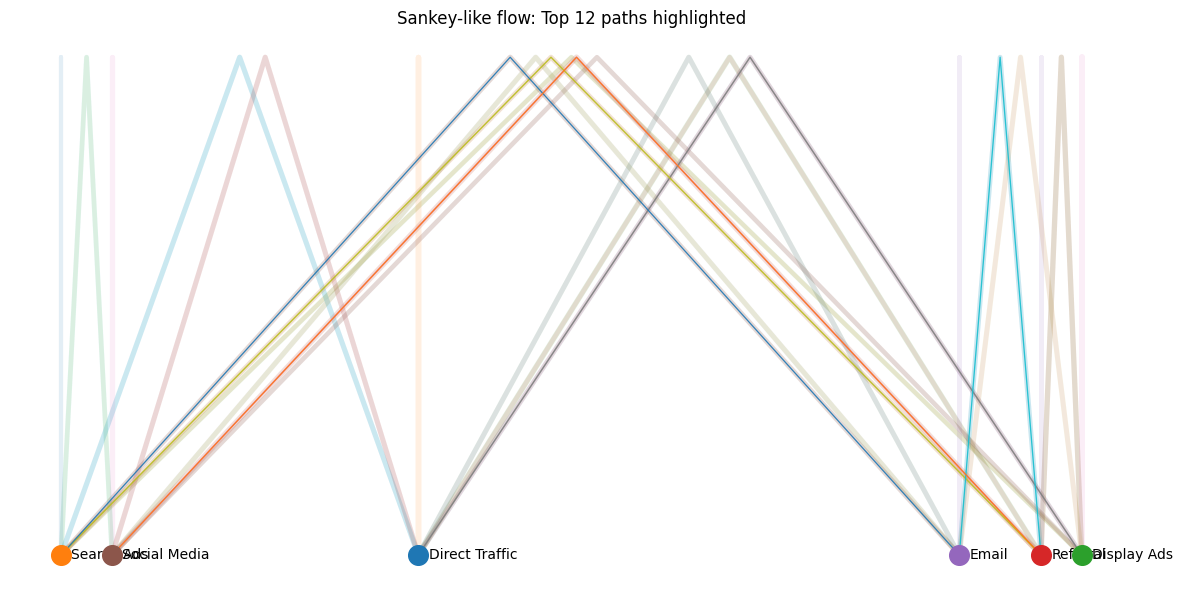

✅ Saved Sankey image to: /content/sankey_flows.png


In [12]:
# Cell 8 — Sankey-like flow visualization (matplotlib)
from collections import Counter, defaultdict
import matplotlib.pyplot as plt
import numpy as np

# Use journeys DataFrame created earlier
paths_str = journeys["Channel"].apply(lambda x: " > ".join(x))
path_counts = paths_str.value_counts().reset_index()
path_counts.columns = ["path_str","count"]
K = 12  # top K paths to highlight; reduce if plots look crowded
top_paths = path_counts.head(K)

# Count edges for top paths (highlight) and all edges (background)
edge_counts = Counter()
for p,cnt in zip(top_paths["path_str"], top_paths["count"]):
    chs = p.split(" > ")
    for a,b in zip(chs, chs[1:]):
        edge_counts[(a,b)] += cnt

all_edges = Counter()
for p in journeys["Channel"]:
    for a,b in zip(p, p[1:]):
        all_edges[(a,b)] += 1

# Build nodes and approximate x positions by average step index
nodes = sorted({n for e in set(list(edge_counts.keys()) + list(all_edges.keys())) for n in e})
channel_positions = defaultdict(list)
for p in journeys["Channel"]:
    for idx,ch in enumerate(p):
        channel_positions[ch].append(idx)
avg_pos = {ch: np.mean(idxs) for ch,idxs in channel_positions.items()}
minp, maxp = min(avg_pos.values()), max(avg_pos.values())
norm_pos = {ch:(avg_pos[ch]-minp)/(maxp-minp) if maxp>minp else 0.5 for ch in avg_pos}

# Group by x and assign y positions per group
groups = defaultdict(list)
for ch, x in norm_pos.items():
    groups[round(x,2)].append(ch)
node_coords = {}
for x_group, chs in groups.items():
    x = float(x_group)
    n = len(chs)
    for i,ch in enumerate(sorted(chs)):
        y = 1.0 - (i+1)/(n+1)
        node_coords[ch] = (x, y)
# fallback positions
for ch in nodes:
    if ch not in node_coords:
        node_coords[ch] = (0.5, 0.5)

# Draw plot
plt.figure(figsize=(12,6))
ax = plt.gca(); ax.axis('off')
max_count = max(all_edges.values()) if all_edges else 1

def draw_edge(a,b,count,alpha=0.3,z=1,linewidth_scale=6):
    (x1,y1) = node_coords[a]; (x2,y2) = node_coords[b]
    xm = (x1+x2)/2; ctrl_y = max(y1,y2) + 0.15
    xs = [x1, xm, x2]; ys = [y1, ctrl_y, y2]
    lw = max(0.5, (count/max_count)*linewidth_scale)
    ax.plot(xs, ys, linewidth=lw, alpha=alpha, zorder=z, solid_capstyle='round')

# Draw background edges faintly
for (a,b), cnt in all_edges.items():
    draw_edge(a,b,cnt,alpha=0.12,z=1,linewidth_scale=4)
# Highlight top-path edges
for (a,b), cnt in edge_counts.items():
    draw_edge(a,b,cnt,alpha=0.9,z=3,linewidth_scale=10)

# Draw nodes and labels
for ch,(x,y) in node_coords.items():
    ax.scatter([x],[y], s=200, zorder=4)
    ax.text(x+0.01, y, ch, va='center', fontsize=10)

plt.title(f"Sankey-like flow: Top {K} paths highlighted")
plt.tight_layout()
out_png = "/content/sankey_flows.png"
plt.savefig(out_png, dpi=150, bbox_inches="tight")
plt.show()
print("✅ Saved Sankey image to:", out_png)


**List artifacts produced (quick check)**

In [14]:
# Cell X — list produced artifacts so you can confirm before zipping
import os, glob
files = glob.glob("/content/*")
artifacts = [f for f in files if any(x in f for x in ["anonymized_attribution.csv","rule_based_attribution","markov_attribution","shapley","sankey_flows","damabytes_attribution_project.zip"])]
print("Artifacts found in /content:")
for f in artifacts:
    print(" -", os.path.basename(f))


Artifacts found in /content:
 - shapley_vs_markov_comparison.png
 - rule_based_attribution.png
 - anonymized_attribution.csv
 - shapley_attribution_comparison.csv
 - markov_attribution_comparison.csv
 - rule_based_attribution.csv
 - sankey_flows.png
 - markov_attribution.png


**Package artifacts into a ZIP and download**

In [15]:
# Cell 9 — Zip artifacts and provide download
import zipfile, os
from google.colab import files

files_to_include = [
    "/content/anonymized_attribution.csv",
    "/content/rule_based_attribution.csv",
    "/content/rule_based_attribution.png",
    "/content/markov_attribution_comparison.csv",
    "/content/markov_attribution.png",
    "/content/shapley_attribution_comparison.csv",
    "/content/shapley_vs_markov_comparison.png",
    "/content/sankey_flows.png"
]

existing = [f for f in files_to_include if os.path.exists(f)]
zip_name = "/content/damabytes_attribution_project.zip"
with zipfile.ZipFile(zip_name, "w") as z:
    for f in existing:
        z.write(f, arcname=os.path.basename(f))

print("✅ Created zip:", zip_name)
print("Files included:", [os.path.basename(f) for f in existing])

# Trigger download in browser
files.download(zip_name)


✅ Created zip: /content/damabytes_attribution_project.zip
Files included: ['anonymized_attribution.csv', 'rule_based_attribution.csv', 'rule_based_attribution.png', 'markov_attribution_comparison.csv', 'markov_attribution.png', 'shapley_attribution_comparison.csv', 'shapley_vs_markov_comparison.png', 'sankey_flows.png']


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>